# Michibiki Data

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from spacepy import pycdf
from scipy.ndimage import uniform_filter1d

Functions to load noise

In [55]:
import utility
B = utility.load_michibiki_data() # shape = (n_sensor, n_axis, n_samples)
#B = B[:,:,::10]
noise = B[0] - B[1]

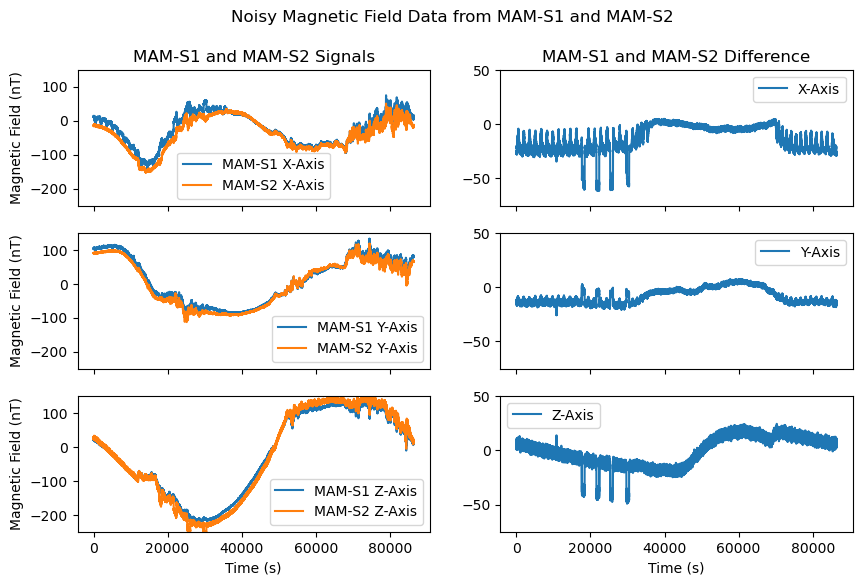

In [56]:
"Create a 3 x 2-panel plot of MAM-S1 and MAM-S2 data with overlapping magnetometers in the same panel"
fig, axs = plt.subplots(3, 2, figsize=(10, 6), sharex=True)
fig.suptitle("Noisy Magnetic Field Data from MAM-S1 and MAM-S2")
axs[0,0].set_title("MAM-S1 and MAM-S2 Signals")
axs[0,0].plot(B[0,0], label="MAM-S1 X-Axis")
axs[0,0].plot(B[1,0], label="MAM-S2 X-Axis")
axs[0,0].set_ylabel("Magnetic Field (nT)")
axs[0,0].set_ylim(-250, 150)
axs[0,0].legend()

axs[1,0].plot(B[0,1], label="MAM-S1 Y-Axis")
axs[1,0].plot(B[1,1], label="MAM-S2 Y-Axis")
axs[1,0].set_ylabel("Magnetic Field (nT)")
axs[1,0].set_ylim(-250, 150)
axs[1,0].legend()

axs[2,0].plot(B[0,2], label="MAM-S1 Z-Axis")
axs[2,0].plot(B[1,2], label="MAM-S2 Z-Axis")
axs[2,0].set_xlabel("Time (s)")
axs[2,0].set_ylabel("Magnetic Field (nT)")
axs[2,0].set_ylim(-250, 150)
axs[2,0].legend()

axs[0,1].set_title("MAM-S1 and MAM-S2 Difference")
axs[0,1].plot(B[1,0]-B[0,0], label="X-Axis")
axs[0,1].legend()
axs[0,1].set_ylim(-75, 50)

axs[1,1].plot(B[1,1]-B[0,1], label="Y-Axis")
axs[1,1].legend()
axs[1,1].set_ylim(-75, 50)

axs[2,1].plot(B[1,2]-B[0,2], label="Z-Axis")
axs[2,1].set_ylim(-75, 50)
axs[2,1].set_xlabel("Time (s)")
axs[2,1].legend()

plt.show()



Find Coupling Coefficients

In [62]:
from algorithms import RAMEN
from scipy.stats import pearsonr
import importlib
importlib.reload(RAMEN)

axis = 1
RAMEN.fs = 1
RAMEN.weights = np.geomspace(1,.1,B.shape[0])
RAMEN.sspTol = 5
RAMEN.flip = False

result_ramen = RAMEN.clean(np.copy(B[:,axis]), triaxial=False)

print(pearsonr(result_ramen, noise[axis])[0])
print(pearsonr(B[-1,axis], noise[axis])[0])
print(RAMEN.aii)

0.05983364642467797
0.08329265168860411
[[1.         1.        ]
 [1.         5.38511696]]


c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\algorithms\RAMEN.py:123: RuntimeWarning: invalid value encountered in divide
  alpha_ij = np.nanmean(np.abs(B_filtered[i]) / np.abs(B_filtered[0]), axis=-1)


In [ ]:
plt.plot()

In [63]:
from algorithms import WAICUPV2
importlib.reload(WAICUPV2)
WAICUPV2.fs = .1
WAICUPV2.uf=400
WAICUPV2.detrend = True
#WAICUPV2.weights = np.geomspace(1,.1,B.shape[0])
WAICUPV2.gain_method = 'sheinker'
WAICUPV2.sspTol = 5
WAICUPV2.flip = False
result_waicup = WAICUPV2.clean(np.copy(B[:,axis]), triaxial=False)
print(pearsonr(result_waicup, noise[axis])[0])
print(pearsonr(B[-1,axis], noise[axis])[0])

c:\Users\alexp\OneDrive\Documents\GitHub\MAGPRIME\magprime\algorithms\WAICUPV2.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  w_clean[s] = HOG(wn[:,s,:])


0.03211826716051439
0.08329265168860411


In [71]:
from algorithms import HOG
importlib.reload(HOG)

HOG.fs = .1
HOG.weights = np.geomspace(10,.1,B.shape[0])
HOG.sspTol = 14
HOG.gain_method = 'sheinker'
HOG.flip = True
result_hog= HOG.clean(np.copy(B[:,axis]), triaxial=False)
print(pearsonr(result_hog, noise[axis])[0])
B2 = np.array([B[0,axis], B[1,axis], result_hog])
HOG.weights = np.geomspace(10,.1,B2.shape[0])
result_hog= HOG.clean(np.copy(B2), triaxial=False)
print(pearsonr(result_hog, noise[axis])[0])
B3 = np.array([B2[0], B2[1],B2[2], result_hog])
HOG.weights = np.geomspace(10,.1,B3.shape[0])
result_hog= HOG.clean(np.copy(B3), triaxial=False)
print(pearsonr(result_hog, noise[axis])[0])
print(pearsonr(B[-1,axis], noise[axis])[0])
#print(HOG.aii)

0.07078509423688155
0.06809485769363967
0.06841905960993919
0.08329265168860411


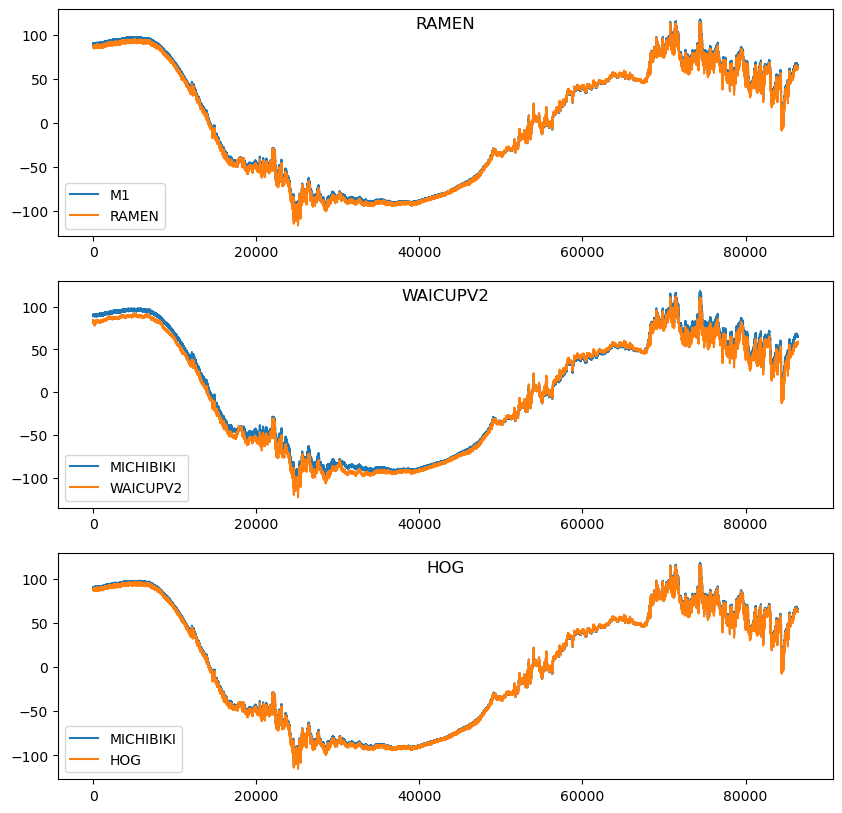

In [72]:
# Make 3,1 subplot and overlay swarm on each result. Set location of each title to within the plot
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
#axs[0].plot(B[0,axis], label = 'M0')
axs[0].plot(B[-1,axis], label = 'M1')
axs[0].plot(result_ramen, label = 'RAMEN')
axs[0].set_title("RAMEN", y=1.0, pad=-14)
axs[0].legend()
axs[1].plot(B[-1,axis], label = 'MICHIBIKI')
axs[1].plot(result_waicup, label = 'WAICUPV2')

axs[1].set_title('WAICUPV2', y=1.0, pad=-14)
axs[1].legend()
axs[2].plot(B[-1,axis], label = 'MICHIBIKI')
axs[2].plot(result_hog, label = 'HOG')

axs[2].set_title('HOG', y=1.0, pad=-14)
axs[2].legend()


In [ ]:
"Take Continuous Wavelet Transform"
import fcwt
fs= 1  # Hz
f0 = 0.0001  # Hz
f1 = 25 / 2  # Hz


# take transform of B_kplo Z-axis
freqs, out = fcwt.cwt(B[2,2], fs_waicup_kplo, f0, f1, fn=300, scaling='log', nthreads=12)
freqs = np.flip(freqs)
